## Using outer join to select actors

* [3. Advanced Merging and Concatenating](#3.-Advanced-Merging-and-Concatenating)
    * [Anti-join example](#Anti-join-example)
    * [Semi-join](#Semi-join)
* [Concatenate DataFrames together vertically](#Concatenate-DataFrames-together-vertically)
 * [Simple](#Simple)
 * [With ignore_index parameter](#With-ignore_index-parameter)
 * [Concatenating with 'keys' parameter](#Concatenating-with-'keys'-parameter)
     * [Example 1](#Example-1)
     * [Example 2: 'keys' parameter is usefull for aggregation](#Example-2:-'keys'-parameter-is-usefull-for-aggregation)

In [72]:
import os
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
DATAPATH = Path('data').absolute()

In [4]:
actors_movies = pd.read_csv(DATAPATH / "actors_movies.csv")
actors_movies.head()

,Actor,Title
0,"[Emil Eifrem,Hugo Weaving,Laurence Fishburne,C...",The Matrix
1,"[Hugo Weaving,Laurence Fishburne,Carrie-Anne M...",The Matrix Reloaded
2,"[Hugo Weaving,Laurence Fishburne,Carrie-Anne M...",The Matrix Revolutions
3,"[Al Pacino,Charlize Theron,Keanu Reeves]",The Devil's Advocate
4,"[James Marshall,Kevin Pollak,J.T. Walsh,Aaron ...",A Few Good Men


In [5]:
actors_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Actor   35 non-null     object
 1   Title   35 non-null     object
dtypes: object(2)
memory usage: 688.0+ bytes


In [6]:
actors_movies.Title.str.lower()

0                          the matrix
1                 the matrix reloaded
2              the matrix revolutions
3                the devil's advocate
4                      a few good men
5                             top gun
6                       jerry maguire
7                         stand by me
8                  as good as it gets
9                what dreams may come
10             snow falling on cedars
11                    you've got mail
12               sleepless in seattle
13             joe versus the volcano
14                  that thing you do
15                   the replacements
16                         rescuedawn
17                       the birdcage
18                         unforgiven
19                    johnny mnemonic
20                        cloud atlas
21                  the da vinci code
22                     v for vendetta
23                        speed racer
24                     ninja assassin
25                     the green mile
26          

In [7]:
movies = pd.read_pickle(DATAPATH / "movies.p")
movies.head()

,id,title,popularity,release_date
0,257,Oliver Twist,20.415572,2005-09-23
1,14290,Better Luck Tomorrow,3.877036,2002-01-12
2,38365,Grown Ups,38.864027,2010-06-24
3,9672,Infamous,3.680896,2006-11-16
4,12819,Alpha and Omega,12.300789,2010-09-17


### Exercise 2.3.1 Merging a table to itself

In [8]:
sequels = pd.read_pickle(DATAPATH / "sequels.p")
sequels.head()

,id,title,sequel
0,19995,Avatar,<NA>
1,862,Toy Story,863
2,863,Toy Story 2,10193
3,597,Titanic,<NA>
4,24428,The Avengers,<NA>


In [9]:
sequels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      4803 non-null   Int64 
 1   title   4803 non-null   object
 2   sequel  90 non-null     Int64 
dtypes: Int64(2), object(1)
memory usage: 122.1+ KB


In [10]:
crews = pd.read_pickle(DATAPATH / "crews.p")
crews.head()

,id,department,job,name
0,19995,Editing,Editor,Stephen E. Rivkin
2,19995,Sound,Sound Designer,Christopher Boyes
4,19995,Production,Casting,Mali Finn
6,19995,Directing,Director,James Cameron
7,19995,Writing,Writer,James Cameron


In [11]:
crews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42502 entries, 0 to 129580
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          42502 non-null  int64 
 1   department  42502 non-null  object
 2   job         42502 non-null  object
 3   name        42502 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.6+ MB


In [12]:
# Merge the crews table to itself
crews_self_merged = crews.merge(crews, on='id', how='inner', suffixes=('_dir','_crew'))
crews_self_merged.head()

,id,department_dir,job_dir,name_dir,department_crew,job_crew,name_crew
0,19995,Editing,Editor,Stephen E. Rivkin,Editing,Editor,Stephen E. Rivkin
1,19995,Editing,Editor,Stephen E. Rivkin,Sound,Sound Designer,Christopher Boyes
2,19995,Editing,Editor,Stephen E. Rivkin,Production,Casting,Mali Finn
3,19995,Editing,Editor,Stephen E. Rivkin,Directing,Director,James Cameron
4,19995,Editing,Editor,Stephen E. Rivkin,Writing,Writer,James Cameron


In [13]:
crews_self_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 834194 entries, 0 to 834193
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               834194 non-null  int64 
 1   department_dir   834194 non-null  object
 2   job_dir          834194 non-null  object
 3   name_dir         834194 non-null  object
 4   department_crew  834194 non-null  object
 5   job_crew         834194 non-null  object
 6   name_crew        834194 non-null  object
dtypes: int64(1), object(6)
memory usage: 50.9+ MB


### Self join

**Merging a table to itself can be useful when we want to compare values in a column to other values in the same column.** We will create a table that for each movie will list the movie director and a member of the crew on one row. We have been given a table called crews, which has columns `id`, `job`, and `name`. First, we merge the table to itself using the movie ID. This merge will give us a larger table where for each movie, every job is matched against each other. Then we select only those rows with a director in the left table, and avoid having a row where the director's job is listed in both the left and right tables. This filtering will remove job combinations that aren't with the director.

In [14]:
# Create a boolean index to select the appropriate rows
boolean_filter = ((crews_self_merged['job_dir'] == 'Director') & 
                  (crews_self_merged['job_crew'] != 'Director'))

direct_crews = crews_self_merged[boolean_filter]
direct_crews.head()

,id,department_dir,job_dir,name_dir,department_crew,job_crew,name_crew
156,19995,Directing,Director,James Cameron,Editing,Editor,Stephen E. Rivkin
157,19995,Directing,Director,James Cameron,Sound,Sound Designer,Christopher Boyes
158,19995,Directing,Director,James Cameron,Production,Casting,Mali Finn
160,19995,Directing,Director,James Cameron,Writing,Writer,James Cameron
161,19995,Directing,Director,James Cameron,Art,Set Designer,Richard F. Mays


By merging the table to itself, we compared the value of the director from the jobs column to other values from the jobs column. With the output, we can quickly see different movie directors and the people they worked with in the same movie.

## Section 2.3 Merging on indexes
### Exercise 2.3.1 Index merge for movie ratings

To practice merging on indexes, you will merge `movies` and a table called `ratings` that holds info about movie ratings. Make sure your merge returns all of the rows from the `movies`table and not all the rows of `ratings` table need to be included in the result.

In [15]:
ratings = pd.read_pickle(DATAPATH / "ratings.p")
ratings.head()

,id,vote_average,vote_count
0,19995,7.2,11800.0
1,285,6.9,4500.0
2,206647,6.3,4466.0
3,49026,7.6,9106.0
4,49529,6.1,2124.0


In [16]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            4803 non-null   int64  
 1   vote_average  4803 non-null   float64
 2   vote_count    4741 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 112.7 KB


In [17]:
# Merge to the movies table the ratings table on the index
movies_ratings = movies.merge(ratings, left_index=True, right_index=True, how='left')
movies_ratings.head()

,id_x,title,popularity,release_date,id_y,vote_average,vote_count
0,257,Oliver Twist,20.415572,2005-09-23,19995,7.2,11800.0
1,14290,Better Luck Tomorrow,3.877036,2002-01-12,285,6.9,4500.0
2,38365,Grown Ups,38.864027,2010-06-24,206647,6.3,4466.0
3,9672,Infamous,3.680896,2006-11-16,49026,7.6,9106.0
4,12819,Alpha and Omega,12.300789,2010-09-17,49529,6.1,2124.0


### Exercise 2.4.2 Do sequels earn more?
<p>It is time to put together many of the aspects that you have learned in this chapter. In this exercise, you'll find out which movie sequels earned the most compared to the original movie. To answer this question, you will merge a modified version of the <code>sequels</code> and <code>financials</code> tables where their index is the movie ID. You will need to choose a merge type that will return all of the rows from the <code>sequels</code> table and not all the rows of <code>financials</code> table need to be included in the result. From there, you will join the resulting table to itself so that you can compare the revenue values of the original movie to the sequel. Next, you will calculate the difference between the two revenues and sort the resulting dataset. </p><p>The <code>sequels</code> and <code>financials</code> tables have been provided.</p>

#### Instructions

<ul><li>With the <code>sequels</code> table on the left, merge to it the <code>financials</code> table on index named <code>id</code>, ensuring that all the rows from the <code>sequels</code> are returned and some rows from the other table may not be returned, Save the results to <code>sequels_fin</code>.</li></ul>

In [18]:
financials = pd.read_pickle(DATAPATH / "financials.p")
financials.head()

,id,budget,revenue
0,19995,237000000,2.787965e+09
1,285,300000000,9.610000e+08
2,206647,245000000,8.806746e+08
3,49026,250000000,1.084939e+09
4,49529,260000000,2.841391e+08


In [19]:
# Merge sequels and financials on index id
sequels_fin = (sequels
               .merge(financials, how='left', left_index=True, right_index=True, suffixes=('', '_y'))
               .drop('id_y', axis=1)
               .set_index('id'))
sequels_fin.head()

,title,sequel,budget,revenue
id,,,,
19995,Avatar,<NA>,237000000.0,2.787965e+09
862,Toy Story,863,300000000.0,9.610000e+08
863,Toy Story 2,10193,245000000.0,8.806746e+08
597,Titanic,<NA>,250000000.0,1.084939e+09
24428,The Avengers,<NA>,260000000.0,2.841391e+08


In [20]:
# Self merge with suffixes as inner join with left on sequel and right on id
orig_seq = sequels_fin.merge(sequels_fin, how='inner', left_on='sequel', 
                             right_on='id', right_index=True,
                             suffixes=('_org','_seq'))
orig_seq.head()

,sequel,title_org,sequel_org,budget_org,revenue_org,title_seq,sequel_seq,budget_seq,revenue_seq
id,,,,,,,,,
862,863,Toy Story,863,300000000.0,9.610000e+08,Toy Story 2,10193,245000000.0,8.806746e+08
863,10193,Toy Story 2,10193,245000000.0,8.806746e+08,Toy Story 3,<NA>,380000000.0,1.045714e+09
675,767,Harry Potter and the Order of the Phoenix,767,200000000.0,7.837663e+08,Harry Potter and the Half-Blood Prince,<NA>,200000000.0,1.215440e+09
121,122,The Lord of the Rings: The Two Towers,122,200000000.0,1.025491e+09,The Lord of the Rings: The Return of the King,<NA>,255000000.0,8.928991e+07
120,121,The Lord of the Rings: The Fellowship of the Ring,121,190000000.0,1.506249e+09,The Lord of the Rings: The Two Towers,122,200000000.0,1.025491e+09


In [21]:
# Add calculation to subtract revenue_org from revenue_seq 
orig_seq['diff'] = orig_seq['revenue_seq'] - orig_seq['revenue_org']

# Select the title_org, title_seq, and diff 
titles_diff = orig_seq[['title_org','title_seq','diff']]
titles_diff.sort_values(by='diff', ascending=False).head()

,title_org,title_seq,diff
id,,,
3049,Ace Ventura: Pet Detective,Ace Ventura: When Nature Calls,1.039243e+09
8966,Twilight,The Twilight Saga: New Moon,6.775028e+08
10138,Iron Man 2,Iron Man 3,6.579765e+08
61791,Rise of the Planet of the Apes,Dawn of the Planet of the Apes,5.895793e+08
331,Jurassic Park III,Jurassic World,5.578606e+08


# 3. Advanced Merging and Concatenating

In this chapter, you'll leverage powerful filtering techniques, including semi-joins and anti-joins. You’ll also learn how to glue DataFrames by vertically combining and using the pandas.concat function to create new datasets. Finally, because data is rarely clean, you’ll also learn how to validate your newly combined data structures.

Tags: semi-join, anti-join.

## Anti-join example

<div style="text-align:center;">
    <img src="img/anti_join.png" style="width:500px;">
</div>

In [22]:
movies_financials = movies.merge(financials, on='id', how='left', indicator=True)
movies_financials.head()

,id,title,popularity,release_date,budget,revenue,_merge
0,257,Oliver Twist,20.415572,2005-09-23,50000000.0,42093706.0,both
1,14290,Better Luck Tomorrow,3.877036,2002-01-12,NaN,NaN,left_only
2,38365,Grown Ups,38.864027,2010-06-24,80000000.0,271430189.0,both
3,9672,Infamous,3.680896,2006-11-16,13000000.0,1151330.0,both
4,12819,Alpha and Omega,12.300789,2010-09-17,20000000.0,39300000.0,both


In [23]:
# Select the vid column where _merge is left_only
id_list = movies_financials.loc[movies_financials['_merge'] == 'left_only', 'id']
id_list

1        14290
7        13785
9        18841
11      158752
15       16186
         ...  
4783     17334
4788     25189
4793    198370
4799     11934
4800     13807
Name: id, Length: 1574, dtype: int64

In [24]:
# Select movies for which there are no financials
movies[movies['id'].isin(id_list)].head()

,id,title,popularity,release_date
1,14290,Better Luck Tomorrow,3.877036,2002-01-12
7,13785,Best in Show,10.982255,2000-09-19
9,18841,The Lost Skeleton of Cadavra,1.680525,2001-09-12
11,158752,Escape from Tomorrow,1.352222,2013-10-11
15,16186,Diary of a Mad Black Woman,3.784535,2005-02-25


As we can observe, there are only movies for which budget and revenue are not available.

In [25]:
movies_financials[movies['id'].isin(id_list)].head()

,id,title,popularity,release_date,budget,revenue,_merge
1,14290,Better Luck Tomorrow,3.877036,2002-01-12,NaN,NaN,left_only
7,13785,Best in Show,10.982255,2000-09-19,NaN,NaN,left_only
9,18841,The Lost Skeleton of Cadavra,1.680525,2001-09-12,NaN,NaN,left_only
11,158752,Escape from Tomorrow,1.352222,2013-10-11,NaN,NaN,left_only
15,16186,Diary of a Mad Black Woman,3.784535,2005-02-25,NaN,NaN,left_only


## Semi-join

<div style="text-align:center;">
    <img src="img/semi_join.png" style="width:500px;">
</div>

1. Returns the intersection, similar to an inner join
1. Returs only columns from the left table and **not** the right
1. Does **not** return **duplicates**

### Steps of a semi-join

<ol>
    <li>Merge the left and right tables on key column using an inner-join.</li>
    <li>Search if the key column in the left table is in the merged tables using the <code>.isin()</code> method creating a Boolean <code>Series</code>.</li>
    <li>Subset the rows of the left table.</li>
</ol>

The datasets we will use are `top_ten_movies` (which we have to create first) and `genres`.

In [26]:
movies.head()

,id,title,popularity,release_date
0,257,Oliver Twist,20.415572,2005-09-23
1,14290,Better Luck Tomorrow,3.877036,2002-01-12
2,38365,Grown Ups,38.864027,2010-06-24
3,9672,Infamous,3.680896,2006-11-16
4,12819,Alpha and Omega,12.300789,2010-09-17


In [27]:
genres = pd.read_pickle(DATAPATH / "movie_to_genres.p")
genres.head()

,movie_id,genre
0,5,Crime
1,5,Comedy
2,11,Science Fiction
3,11,Action
4,11,Adventure


In [28]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            4803 non-null   int64  
 1   title         4803 non-null   object 
 2   popularity    4803 non-null   float64
 3   release_date  4802 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 150.2+ KB


In [29]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12160 entries, 0 to 12159
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  12160 non-null  int64 
 1   genre     12160 non-null  object
dtypes: int64(1), object(1)
memory usage: 190.1+ KB


Create the top ten movies mask by popularity score:

In [30]:
mask = movies.popularity.isin(movies['popularity'].nlargest(10))
mask

0       False
1       False
2       False
3       False
4       False
        ...  
4798    False
4799    False
4800    False
4801    False
4802    False
Name: popularity, Length: 4803, dtype: bool

We get a table with 10 observations corresponding to the 10 preferred movies:

In [31]:
top_ten_movies = movies[mask].reset_index(drop=True)
top_ten_movies

,id,title,popularity,release_date
0,119450,Dawn of the Planet of the Apes,243.791743,2014-06-26
1,135397,Jurassic World,418.708552,2015-06-09
2,293660,Deadpool,514.569956,2016-02-09
3,118340,Guardians of the Galaxy,481.098624,2014-07-30
4,177572,Big Hero 6,203.734590,2014-10-24
5,131631,The Hunger Games: Mockingjay - Part 1,206.227151,2014-11-18
6,76341,Mad Max: Fury Road,434.278564,2015-05-13
7,157336,Interstellar,724.247784,2014-11-05
8,22,Pirates of the Caribbean: The Curse of the Bla...,271.972889,2003-07-09
9,211672,Minions,875.581305,2015-06-17


In [32]:
top_ten_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            10 non-null     int64  
 1   title         10 non-null     object 
 2   popularity    10 non-null     float64
 3   release_date  10 non-null     object 
dtypes: float64(1), int64(1), object(2)
memory usage: 448.0+ bytes


#### Step 1

Merge the left and right tables on key column using an inner-join.

To get the rows where the genres correspond to the top ten movies, we have to perform an inner join between `genres` and `top_ten_movies`.

In [33]:
# Step 1
genres_top_movies = genres.merge(top_ten_movies,
                                 left_on='movie_id',
                                 right_on='id')
genres_top_movies.head()

,movie_id,genre,id,title,popularity,release_date
0,22,Fantasy,22,Pirates of the Caribbean: The Curse of the Bla...,271.972889,2003-07-09
1,22,Adventure,22,Pirates of the Caribbean: The Curse of the Bla...,271.972889,2003-07-09
2,22,Action,22,Pirates of the Caribbean: The Curse of the Bla...,271.972889,2003-07-09
3,76341,Action,76341,Mad Max: Fury Road,434.278564,2015-05-13
4,76341,Science Fiction,76341,Mad Max: Fury Road,434.278564,2015-05-13


In [34]:
genres_top_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 35
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movie_id      36 non-null     int64  
 1   genre         36 non-null     object 
 2   id            36 non-null     int64  
 3   title         36 non-null     object 
 4   popularity    36 non-null     float64
 5   release_date  36 non-null     object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.0+ KB


#### Steps 2 and 3

Search if the key column in the left table is in the merged tables using the `.isin()` method creating a Boolean Series.

<div style="text-align:center;">
    <img src="img/semi_join_step_2.png" style="width:500px;">
</div>

Subset the rows of the left table.

In [35]:
# Steps 2 and 3
top_genres = genres[genres['movie_id'].isin(genres_top_movies['movie_id'])]
top_genres.head()

,movie_id,genre
23,22,Fantasy
24,22,Adventure
25,22,Action
9949,76341,Action
9950,76341,Science Fiction


In [36]:
top_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 23 to 11736
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  36 non-null     int64 
 1   genre     36 non-null     object
dtypes: int64(1), object(1)
memory usage: 864.0+ bytes


## Concatenate DataFrames together vertically

In [37]:
movies.release_date = pd.to_datetime(movies.release_date)

In [38]:
movies_jan = movies[movies.release_date.dt.strftime("%Y-%m") == '2002-01'].head()
movies_jan

,id,title,popularity,release_date
1,14290,Better Luck Tomorrow,3.877036,2002-01-12
39,11022,Narc,8.526635,2002-01-14
194,16653,The Singles Ward,0.920591,2002-01-30
347,99826,The Jimmy Show,0.098351,2002-01-16
459,10229,A Walk to Remember,33.283554,2002-01-25


In [39]:
movies_feb = movies[movies.release_date.dt.strftime("%Y-%m") == '2002-02'].head()
movies_mar = movies[movies.release_date.dt.strftime("%Y-%m") == '2002-03'].head()

### Simple

In [40]:
pd.concat([movies_jan, movies_feb, movies_mar])

,id,title,popularity,release_date
1,14290,Better Luck Tomorrow,3.877036,2002-01-12
39,11022,Narc,8.526635,2002-01-14
194,16653,The Singles Ward,0.920591,2002-01-30
347,99826,The Jimmy Show,0.098351,2002-01-16
459,10229,A Walk to Remember,33.283554,2002-01-25
123,16690,Return to Never Land,15.341196,2002-02-14
183,10592,Hart's War,14.244518,2002-02-15
220,598,City of God,44.356711,2002-02-05
679,10052,Dragonfly,8.927137,2002-02-22
830,102840,Sex With Strangers,0.014406,2002-02-22


### With ignore_index parameter

In [41]:
pd.concat([movies_jan, movies_feb, movies_mar], ignore_index=True)

,id,title,popularity,release_date
0,14290,Better Luck Tomorrow,3.877036,2002-01-12
1,11022,Narc,8.526635,2002-01-14
2,16653,The Singles Ward,0.920591,2002-01-30
3,99826,The Jimmy Show,0.098351,2002-01-16
4,10229,A Walk to Remember,33.283554,2002-01-25
5,16690,Return to Never Land,15.341196,2002-02-14
6,10592,Hart's War,14.244518,2002-02-15
7,598,City of God,44.356711,2002-02-05
8,10052,Dragonfly,8.927137,2002-02-22
9,102840,Sex With Strangers,0.014406,2002-02-22


### With 'join' parameter

Using this parameter will let us specify whether to do an outer or an inner join.

In [43]:
movies.head()

,id,title,popularity,release_date
0,257,Oliver Twist,20.415572,2005-09-23
1,14290,Better Luck Tomorrow,3.877036,2002-01-12
2,38365,Grown Ups,38.864027,2010-06-24
3,9672,Infamous,3.680896,2006-11-16
4,12819,Alpha and Omega,12.300789,2010-09-17


In [44]:
sequels.head()

,id,title,sequel
0,19995,Avatar,<NA>
1,862,Toy Story,863
2,863,Toy Story 2,10193
3,597,Titanic,<NA>
4,24428,The Avengers,<NA>


In [47]:
pd.concat([movies, sequels], sort=True)

,id,popularity,release_date,sequel,title
0,257,20.415572,2005-09-23,<NA>,Oliver Twist
1,14290,3.877036,2002-01-12,<NA>,Better Luck Tomorrow
2,38365,38.864027,2010-06-24,<NA>,Grown Ups
3,9672,3.680896,2006-11-16,<NA>,Infamous
4,12819,12.300789,2010-09-17,<NA>,Alpha and Omega
...,...,...,...,...,...
4798,133931,NaN,NaT,<NA>,Zambezia
4799,309503,NaN,NaT,<NA>,Zipper
4800,34592,NaN,NaT,<NA>,ZMD: Zombies of Mass Destruction
4801,206213,NaN,NaT,<NA>,Zombie Hunter


Performing an inner join on `axis=1` will only keep columns that are common to both tables:

In [48]:
pd.concat([movies, sequels], join='inner', sort=True)

,id,title
0,257,Oliver Twist
1,14290,Better Luck Tomorrow
2,38365,Grown Ups
3,9672,Infamous
4,12819,Alpha and Omega
...,...,...
4798,133931,Zambezia
4799,309503,Zipper
4800,34592,ZMD: Zombies of Mass Destruction
4801,206213,Zombie Hunter


### Concatenating with 'keys' parameter

#### Example 1

In [42]:
pd.concat([movies_jan, movies_feb, movies_mar], ignore_index=False, keys=['jan', 'feb', 'mar'])

id                          title  popularity release_date
jan 1      14290           Better Luck Tomorrow    3.877036   2002-01-12
    39     11022                           Narc    8.526635   2002-01-14
    194    16653               The Singles Ward    0.920591   2002-01-30
    347    99826                 The Jimmy Show    0.098351   2002-01-16
    459    10229             A Walk to Remember   33.283554   2002-01-25
feb 123    16690           Return to Never Land   15.341196   2002-02-14
    183    10592                     Hart's War   14.244518   2002-02-15
    220      598                    City of God   44.356711   2002-02-05
    679    10052                      Dragonfly    8.927137   2002-02-22
    830   102840             Sex With Strangers    0.014406   2002-02-22
mar 60      2752          40 Days and 40 Nights   14.181360   2002-03-01
    524    11452  National Lampoon’s Van Wilder   35.108498   2002-03-29
    1568    4547                     Panic Room   53.043124   2002-03-29
    1724   39541                  Stolen Summer    0.870660   2002-03-22
    1798    2135               The Time Machine   25.978555   2002-03-04

#### Example 2: 'keys' parameter is usefull for aggregation

We first need to create three different tables for demonstrating the concatenation:

In [61]:
financials_movies = financials.merge(movies, how='left', on='id')
financials_movies.sort_values(by='release_date', axis=0, inplace=True)
financials_movies.tail(10)

,id,budget,revenue,title,popularity,release_date
146,43074,144000000,229147509.0,Ghostbusters,66.218060,2016-07-14
2750,345911,4900000,44107032.0,Lights Out,48.170508,2016-07-21
1894,328387,20000000,83707310.0,Nerve,62.933899,2016-07-27
216,324668,120000000,415484914.0,Jason Bourne,62.641286,2016-07-27
1847,376659,20000000,183936074.0,Bad Moms,42.512296,2016-07-28
96,315011,15000000,77000000.0,Shin Godzilla,9.476999,2016-07-29
72,297761,175000000,745000000.0,Suicide Squad,90.237920,2016-08-02
2466,294272,65000000,143695338.0,Pete's Dragon,31.974359,2016-08-10
352,271969,100000000,94061311.0,Ben-Hur,29.608322,2016-08-17
3215,339408,8500000,15861566.0,The Birth of a Nation,9.452808,2016-09-09


In [66]:
finmov_jun = financials_movies[financials_movies.release_date.dt.strftime("%Y-%m") == '2016-06']
finmov_jul = financials_movies[financials_movies.release_date.dt.strftime("%Y-%m") == '2016-07']
finmov_aug = financials_movies[financials_movies.release_date.dt.strftime("%Y-%m") == '2016-08']
finmov_aug

,id,budget,revenue,title,popularity,release_date
72,297761,175000000,745000000.0,Suicide Squad,90.237920,2016-08-02
2466,294272,65000000,143695338.0,Pete's Dragon,31.974359,2016-08-10
352,271969,100000000,94061311.0,Ben-Hur,29.608322,2016-08-17


Once we created our three tables, we can concatenate them together using the `keys`parameter. This will be usefull to group the `revenue` by key specifying `level=0`:

In [68]:
finmov_3months = pd.concat([finmov_jun, finmov_jul, finmov_aug], keys=['6Jun', '7Jul', '8Aug'])
finmov_3months

id     budget      revenue  \
6Jun 239   308531  135000000  245623848.0   
     173   267935  140000000  183345589.0   
     1845  296096   20000000  207945075.0   
     364   291805   90000000  334901337.0   
     2626  301365    7000000    1333124.0   
     861   302699   50000000  216972543.0   
     486   328111   75000000  875958308.0   
     90     47933  165000000  389681935.0   
     921   316152   50000000   25035950.0   
     2278  332567   17000000  119100758.0   
     2434  316727   10000000  118587880.0   
     62    258489  180000000  356743061.0   
7Jul 56    188927  185000000  343471816.0   
     1500  223702   19000000  140752617.0   
     971   325789   25000000   15436808.0   
     146    43074  144000000  229147509.0   
     2750  345911    4900000   44107032.0   
     1894  328387   20000000   83707310.0   
     216   324668  120000000  415484914.0   
     1847  376659   20000000  183936074.0   
     96    315011   15000000   77000000.0   
8Aug 72    297761  175000000  745000000.0   
     2466  294272   65000000  143695338.0   
     352   271969  100000000   94061311.0   

                                                      title  popularity  \
6Jun 239   Teenage Mutant Ninja Turtles: Out of the Shadows   39.873791   
     173                                            The BFG   44.190920   
     1845                                     Me Before You   53.161905   
     364                                   Now You See Me 2   51.535701   
     2626                                    The Neon Demon   38.150787   
     861                               Central Intelligence   45.318703   
     486                            The Secret Life of Pets   31.482872   
     90                        Independence Day: Resurgence   48.775723   
     921                                Free State of Jones   21.589393   
     2278                                      The Shallows   60.829621   
     2434                          The Purge: Election Year   53.727146   
     62                                The Legend of Tarzan   42.741719   
7Jul 56                                    Star Trek Beyond   65.352913   
     1500                                     Sausage Party   66.242737   
     971                                    The Infiltrator   24.672234   
     146                                       Ghostbusters   66.218060   
     2750                                        Lights Out   48.170508   
     1894                                             Nerve   62.933899   
     216                                       Jason Bourne   62.641286   
     1847                                          Bad Moms   42.512296   
     96                                       Shin Godzilla    9.476999   
8Aug 72                                       Suicide Squad   90.237920   
     2466                                     Pete's Dragon   31.974359   
     352                                            Ben-Hur   29.608322   

          release_date  
6Jun 239    2016-06-01  
     173    2016-06-01  
     1845   2016-06-02  
     364    2016-06-02  
     2626   2016-06-08  
     861    2016-06-15  
     486    2016-06-18  
     90     2016-06-22  
     921    2016-06-24  
     2278   2016-06-24  
     2434   2016-06-29  
     62     2016-06-29  
7Jul 56     2016-07-07  
     1500   2016-07-11  
     971    2016-07-13  
     146    2016-07-14  
     2750   2016-07-21  
     1894   2016-07-27  
     216    2016-07-27  
     1847   2016-07-28  
     96     2016-07-29  
8Aug 72     2016-08-02  
     2466   2016-08-10  
     352    2016-08-17

In [70]:
avg_finmov = finmov_3months.groupby(level=0).agg({'revenue': 'mean'}, axis=1)
avg_finmov

,revenue
6Jun,2.562691e+08
7Jul,1.703382e+08
8Aug,3.275855e+08


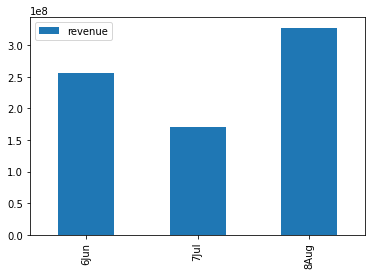

In [90]:
avg_finmov.plot.bar()
ax = plt.gca()
ax.format_ydata = lambda x: f'${x:.2f}'
plt.show()